In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from docx import Document 
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from collections import Counter


### Data Viewing and Merging

In [2]:
# Define file paths
file_paths = [
    'CNN_Articles.xlsx',
    'NYT_Articles.xlsx',
    'USAToday_Articles.xlsx',
    'FOX_Articles.xlsx'
]

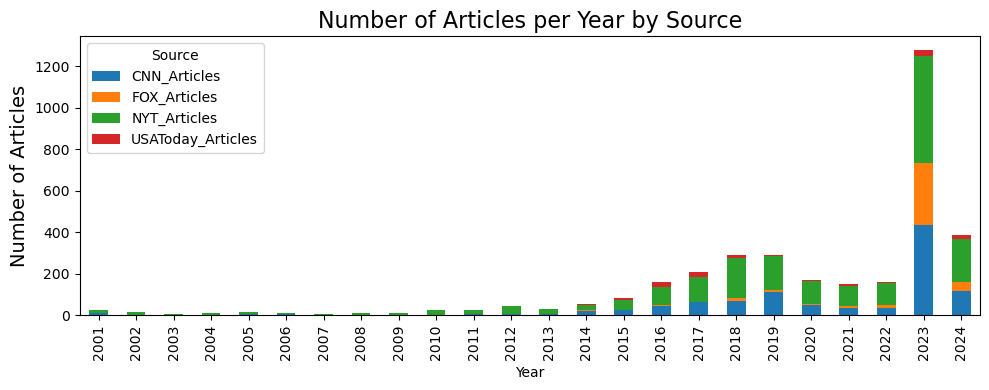

In [5]:
# Initialize an empty DataFrame to store the combined data
all_data = pd.DataFrame()

# Read each file and add a Source column
for file_path in file_paths:
    df = pd.read_excel(file_path)
    source = os.path.splitext(os.path.basename(file_path))[0]
    df['Source'] = source
    all_data = pd.concat([all_data, df], ignore_index=True)

# Convert the Time column to datetime format and extract the year
all_data['Time'] = pd.to_datetime(all_data['Time'], errors='coerce')
all_data['Year'] = all_data['Time'].dt.year

# Count the number of articles per source per year
summary = all_data.groupby(['Year', 'Source']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = summary.plot(kind='bar', stacked=True, figsize=(10, 4))

# Set title and labels
plt.title('Number of Articles per Year by Source', fontsize=16)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Articles', fontsize=14)

# Optimize legend position and adjust layout
plt.legend(title='Source', loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()


In [9]:
# Create an empty DataFrame to store the summary data
all_data = pd.DataFrame()

# Read each file and add a Source column
for file_path in file_paths:
    df = pd.read_excel(file_path)
    source = os.path.splitext(os.path.basename(file_path))[0]
    df['Source'] = source
    all_data = pd.concat([all_data, df], ignore_index=True)

# Save the combined data to a new Excel file
output_excel_path = 'Combined_Articles.xlsx'
all_data.to_excel(output_excel_path, index=False)

# Load the combined data from the saved Excel file to view its information
combined_df = pd.read_excel(output_excel_path)
print(combined_df.info())
print(combined_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    3476 non-null   datetime64[ns]
 1   Body    3476 non-null   object        
 2   Source  3476 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 81.6+ KB
None
                                Time
count                           3476
mean   2020-06-26 06:33:33.348676608
min              2001-02-10 00:00:00
25%              2018-05-09 18:00:00
50%              2022-08-31 00:00:00
75%              2023-07-22 00:00:00
max              2024-05-01 00:00:00


### Data Splitting

In [10]:
# Define time intervals
first_period_end = pd.to_datetime('2014-12-31')
second_period_start = pd.to_datetime('2015-01-01')
second_period_end = pd.to_datetime('2022-11-30')
third_period_start = pd.to_datetime('2022-12-01')
third_period_end = pd.to_datetime('2024-05-01')

# Split the data according to time intervals
first_period_df = combined_df[combined_df['Time'] <= first_period_end]
second_period_df = combined_df[(combined_df['Time'] >= second_period_start) & (combined_df['Time'] <= second_period_end)]
third_period_df = combined_df[(combined_df['Time'] >= third_period_start) & (combined_df['Time'] <= third_period_end)]

# Save the data for each time interval to different Excel files
first_period_path = 'Articles_Upto_2014.xlsx'
second_period_path = 'Articles_2015_to_2022_Nov.xlsx'
third_period_path = 'Articles_2022_Dec_to_2024_May.xlsx'

first_period_df.to_excel(first_period_path, index=False)
second_period_df.to_excel(second_period_path, index=False)
third_period_df.to_excel(third_period_path, index=False)

print("Data after splitting has been saved to files:")
print(first_period_path)
print(second_period_path)
print(third_period_path)

Data after splitting has been saved to files:
Articles_Upto_2014.xlsx
Articles_2015_to_2022_Nov.xlsx
Articles_2022_Dec_to_2024_May.xlsx


In [11]:
# Read each time interval's Excel file
first_period_df = pd.read_excel(first_period_path)
second_period_df = pd.read_excel(second_period_path)
third_period_df = pd.read_excel(third_period_path)

# View the basic information of each dataset
print(first_period_df.describe())
print(second_period_df.describe())
print(third_period_df.describe())


                                Time
count                            296
mean   2009-09-18 01:51:53.513513472
min              2001-02-10 00:00:00
25%              2005-12-03 18:00:00
50%              2011-02-17 12:00:00
75%              2013-03-08 00:00:00
max              2014-12-26 00:00:00
                                Time
count                           1483
mean   2019-01-09 05:56:21.523937792
min              2015-01-01 00:00:00
25%              2017-08-12 12:00:00
50%              2018-12-17 00:00:00
75%              2020-04-12 12:00:00
max              2022-11-30 00:00:00
                                Time
count                           1697
mean   2023-08-23 04:18:48.579846400
min              2022-12-01 00:00:00
25%              2023-05-02 00:00:00
50%              2023-07-27 00:00:00
75%              2023-12-19 00:00:00
max              2024-05-01 00:00:00


### Data Cleaning

In [12]:
# Define a function to clean and filter the data
def clean_and_filter_data(file_name, output_name):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_name)

    # Count occurrences of "artificial intelligence" in each row
    df['ai_count'] = df['Body'].str.count('artificial intelligence', flags=re.IGNORECASE)

    # Filter rows where "artificial intelligence" appears at least 2 times
    filtered_df = df[df['ai_count'] >= 2]

    # Remove the auxiliary 'ai_count' column
    filtered_df = filtered_df.drop(columns=['ai_count'])

    # Remove NaN values in the 'Body' column
    filtered_df.dropna(subset=['Body'], inplace=True)

    # Clean text data: convert all text to lowercase, remove non-alphabetical characters
    filtered_df['Body_Clean'] = filtered_df['Body'].apply(lambda x: re.sub(r'[^a-zA-Z\s]+', '', x.lower()))

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer().fit_transform(filtered_df['Body_Clean'])
    vectors = vectorizer.toarray()

    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(vectors)

    # Set similarity threshold
    similarity_threshold = 0.9

    # Identify duplicate row indices above the threshold
    to_drop = set()
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > similarity_threshold:
                to_drop.add(j)

    # Drop duplicate rows
    filtered_df = filtered_df.drop(filtered_df.index[list(to_drop)])

    # Remove the auxiliary 'Body_Clean' column
    filtered_df = filtered_df.drop(columns=['Body_Clean'])

    # Get the current working directory
    current_dir = os.getcwd()

    # Save the filtered and cleaned DataFrame to a new Excel file
    output_excel_path = os.path.join(current_dir, output_name)
    filtered_df.to_excel(output_excel_path, index=False)
    print("Filtered and cleaned Excel file saved at:", output_excel_path)

# Process each file with the defined function
clean_and_filter_data('Articles_Upto_2014.xlsx', 'Cleaned_Upto2014.xlsx')
clean_and_filter_data('Articles_2015_to_2022_Nov.xlsx', 'Cleaned_2015_2022Nov.xlsx')
clean_and_filter_data('Articles_2022_Dec_to_2024_May.xlsx', 'Cleaned_2022Dec_2024May.xlsx')


Filtered and cleaned Excel file saved at: /Users/lorna/3.Dissertation/Analysis copy/Data/Cleaned_Upto2014.xlsx
Filtered and cleaned Excel file saved at: /Users/lorna/3.Dissertation/Analysis copy/Data/Cleaned_2015_2022Nov.xlsx
Filtered and cleaned Excel file saved at: /Users/lorna/3.Dissertation/Analysis copy/Data/Cleaned_2022Dec_2024May.xlsx
